In [40]:
%reload_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import pyhf
import eos
import numbers
import matplotlib.pyplot as plt
from publik.pyhf_modifier import modifier
from publik.pyhf_modifier import plot

In [41]:
def analysis():
    """
    Specify the likelihoods and FF parameter ranges 
    
    Returns:
        EOS analysis instance
    """

    analysis_args = {
        'global_options': { 'form-factors': 'BSZ2015', 'model': 'CKM' },
        'priors': [
            { 'parameter': 'B->D::alpha^f+_0@BSZ2015', 'min':  0.0,   'max':  1.0   , 'type': 'uniform'},
            { 'parameter': 'B->D::alpha^f+_1@BSZ2015', 'min': -4.0,   'max': -1.0   , 'type': 'uniform'},
            { 'parameter': 'B->D::alpha^f+_2@BSZ2015', 'min': +4.0,   'max': +6.0   , 'type': 'uniform'},
            { 'parameter': 'B->D::alpha^f0_1@BSZ2015', 'min': -1.0,   'max': +2.0   , 'type': 'uniform'},
            { 'parameter': 'B->D::alpha^f0_2@BSZ2015', 'min': -2.0,   'max':  0.0   , 'type': 'uniform'}
        ],
        'likelihood': [
            'B->D::f_++f_0@HPQCD:2015A',
            'B->D::f_++f_0@FNAL+MILC:2015B',
            'B^0->D^+e^-nu::BRs@Belle:2015A',
            'B^0->D^+mu^-nu::BRs@Belle:2015A'
        ]
    }

    analysis = eos.Analysis(**analysis_args)
    analysis.optimize()
    return analysis


## Produce samples

In [42]:
sam_ana = analysis()
sam_cvl = 1.5
sam_csl = 0.5
sam_ana.parameters['cbmunumu::Re{cVL}'       ].set(sam_cvl)
sam_ana.parameters['cbmunumu::Re{cSL}'       ].set(sam_csl)
# TODO how to produce samples according to some BSM model?

In [43]:
mu_kinematics = eos.Kinematics({
    'q2':            2.0,  'q2_min':            0.02,     'q2_max':           11.6,
})
mu_pdf = eos.SignalPDF.make(
    'B->Dlnu::dGamma/dq2', 
    # sam_ana.parameters, 
    eos.Parameters(),
    mu_kinematics, 
    eos.Options({'form-factors': 'BSZ2015', 'l': 'mu', 'model':'WET'}))
rng = np.random.mtrand.RandomState(74205)
mu_samples, mu_weights = mu_pdf.sample_mcmc(N=50000, stride=5, pre_N=1000, preruns=3, rng=rng)

(<Figure size 800x550 with 1 Axes>,
 <Axes: xlabel='$q^2$\\,[$\\textnormal{GeV}^2$]', ylabel='$P(q^2)$'>)

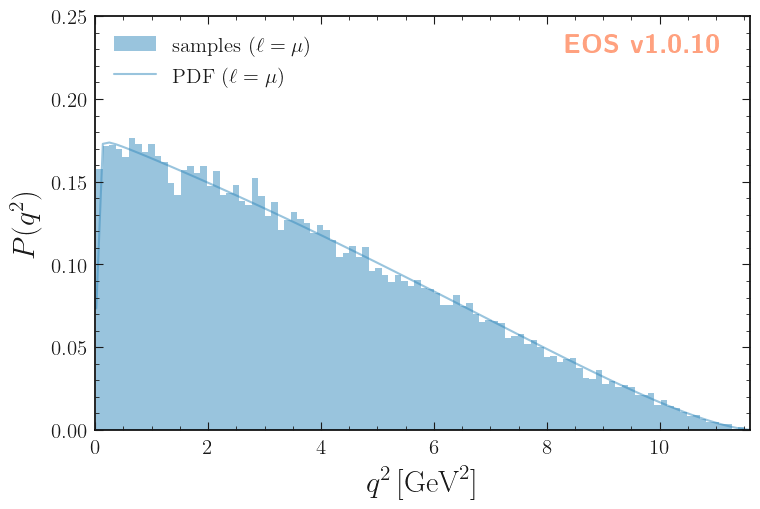

In [44]:
plot_args = {
    'plot': {
        'x': { 'label': r'$q^2$', 'unit': r'$\textnormal{GeV}^2$', 'range': [0.0, 11.60] },
        'y': { 'label': r'$P(q^2)$',                               'range': [0.0,  0.25] },
        'legend': { 'location': 'upper left' }
    },
    'contents': [
        {
            'label': r'samples ($\ell=\mu$)',
            'type': 'histogram',
            'data': {
                'samples': mu_samples
            },
            'color': 'C0'
        },
        {
            'label': r'PDF ($\ell=\mu$)',
            'type': 'signal-pdf',
            'pdf': 'B->Dlnu::dGamma/dq2;l=mu',
            'kinematic': 'q2',
            'range': [0.02, 11.60],
            'kinematics': {
                'q2_min':  0.02,
                'q2_max': 11.60,
            },
            'color': 'C0'
        },
    ]
}
eos.plot.Plotter(plot_args).plot()

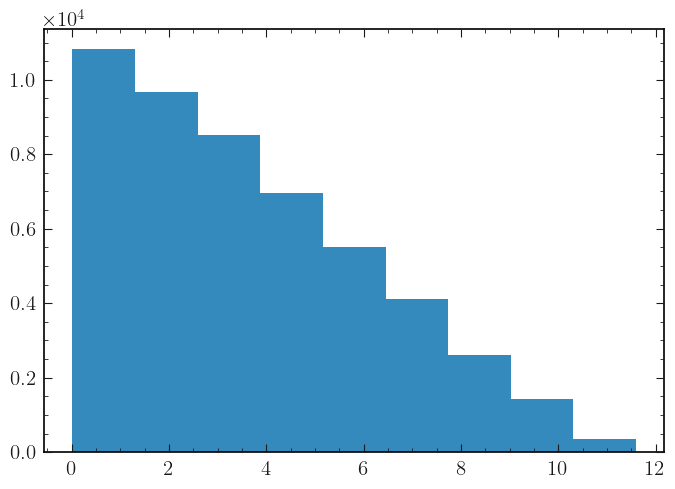

In [45]:
binning = np.linspace(0.02, 11.6, 10) 

nominal, _, _ = plt.hist(mu_samples, binning)

## Define null and alternative predictions

In [46]:
ana = analysis()
cvl = ana.parameters['cbmunumu::Re{cVL}'       ].evaluate()
csl = ana.parameters['cbmunumu::Re{cSL}'       ].evaluate()
fp0 = ana.parameters['B->D::alpha^f+_0@BSZ2015'].evaluate()
fp1 = ana.parameters['B->D::alpha^f+_1@BSZ2015'].evaluate()
fp2 = ana.parameters['B->D::alpha^f+_2@BSZ2015'].evaluate()
f01 = ana.parameters['B->D::alpha^f0_1@BSZ2015'].evaluate()
f02 = ana.parameters['B->D::alpha^f0_2@BSZ2015'].evaluate()

In [47]:
class null:
    def __init__(self):
        self.parameters = eos.Parameters()
        self.options = eos.Options({'form-factors': 'BSZ2015', 'l': 'mu'})

    def distribution(self, q2):
        if isinstance(q2, numbers.Number):
            obs = eos.Observable.make(
                'B->Dlnu::dBR/dq2', 
                self.parameters, 
                eos.Kinematics(q2=q2),
                self.options).evaluate()
        else:
            obs = np.array([eos.Observable.make(
                'B->Dlnu::dBR/dq2', 
                self.parameters, 
                eos.Kinematics(q2=q),
                self.options).evaluate() 
                   for q in q2])
            
        return obs
    
class alt:
    def __init__(self):
        self.ana = analysis()
        self.options = eos.Options({'form-factors': 'BSZ2015', 'l': 'mu', 'model':'WET'})

    def distribution(self, q2, cvl, csl, fp0, fp1, fp2, f01, f02):
        self.ana.parameters['cbmunumu::Re{cVL}'       ].set(cvl)
        self.ana.parameters['cbmunumu::Re{cSL}'       ].set(csl)
        self.ana.parameters['B->D::alpha^f+_0@BSZ2015'].set(fp0)
        self.ana.parameters['B->D::alpha^f+_1@BSZ2015'].set(fp1)
        self.ana.parameters['B->D::alpha^f+_2@BSZ2015'].set(fp2)
        self.ana.parameters['B->D::alpha^f0_1@BSZ2015'].set(f01)
        self.ana.parameters['B->D::alpha^f0_2@BSZ2015'].set(f02)

        if isinstance(q2, numbers.Number):
            obs = eos.Observable.make(
                'B->Dlnu::dBR/dq2', 
                self.ana.parameters, 
                eos.Kinematics(q2=q2),
                self.options).evaluate()
        else:
            obs = np.array([eos.Observable.make(
                'B->Dlnu::dBR/dq2', 
                self.ana.parameters, 
                eos.Kinematics(q2=q),
                self.options).evaluate() 
                   for q in q2])
            
        return obs
    
null = null()
alt = alt()

In [48]:
# TODO better way to get covariance matrix ?
pars, _ = alt.ana.sample(N=5000, stride=5, pre_N=1000, preruns=3, rng=rng)
cov = np.cov(pars.T).tolist()
pd.DataFrame(cov).style.background_gradient(cmap='RdBu')

,0,1,2,3,4
0,0.000064,0.000599,-0.000413,0.000908,0.001553
1,0.000599,0.012193,0.019556,0.012564,0.024469
2,-0.000413,0.019556,0.310870,-0.000531,0.050105
3,0.000908,0.012564,-0.000531,0.018802,0.043011
4,0.001553,0.024469,0.050105,0.043011,0.305721


## Set up mapping distribution

In [49]:
mapping_dist = np.diag(nominal)
# TODO make more realistic mapping distribution

## Set up the custom modifier

In [50]:
# Predicted yields for cvl = csl = 0.5
alt_yields = [
    3060.11993791, 3291.07870052, 3498.17781623, 3511.67481092,
    3491.33134808, 3427.05956019, 3063.72913742, 2741.03878409,
    1658.45873021
    ]

In [51]:
new_params = {
                'cvl'   :{'inits': (1.,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'csl'   :{'inits': (0.,), 'bounds': ((0., 10.),), 'paramset_type': 'unconstrained'},
                'FF'   :{'inits': (fp0, fp1, fp2, f01, f02), 
                         'bounds': ((0., 1.),(-4., -1.),(4., 6.),(-1., 2.),(-2., 0.)), 
                         'cov': cov, 
                         'paramset_type': 'constrained_by_normal'}
            }

cmod = modifier.Modifier(new_params, alt.distribution, null.distribution, mapping_dist, binning)
cmod.expanded_pyhf

{'custom': (publik.pyhf_modifier.custom_modifier.add.<locals>._builder,
  publik.pyhf_modifier.custom_modifier.add.<locals>._applier),
 'histosys': (pyhf.modifiers.histosys.histosys_builder,
  pyhf.modifiers.histosys.histosys_combined),
 'lumi': (pyhf.modifiers.lumi.lumi_builder, pyhf.modifiers.lumi.lumi_combined),
 'normfactor': (pyhf.modifiers.normfactor.normfactor_builder,
  pyhf.modifiers.normfactor.normfactor_combined),
 'normsys': (pyhf.modifiers.normsys.normsys_builder,
  pyhf.modifiers.normsys.normsys_combined),
 'shapefactor': (pyhf.modifiers.shapefactor.shapefactor_builder,
  pyhf.modifiers.shapefactor.shapefactor_combined),
 'shapesys': (pyhf.modifiers.shapesys.shapesys_builder,
  pyhf.modifiers.shapesys.shapesys_combined),
 'staterror': (pyhf.modifiers.staterror.staterror_builder,
  pyhf.modifiers.staterror.staterror_combined)}

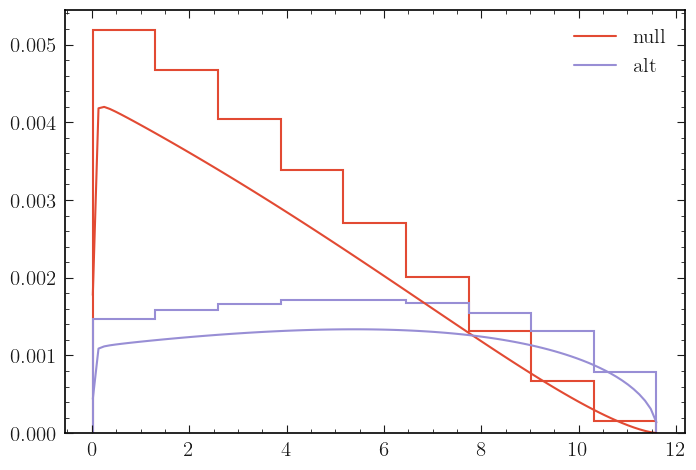

weights :  [0.28258564 0.33991724 0.41097014 0.50404404 0.63363545 0.8303997
 1.17249489 1.93303158 4.84929453]


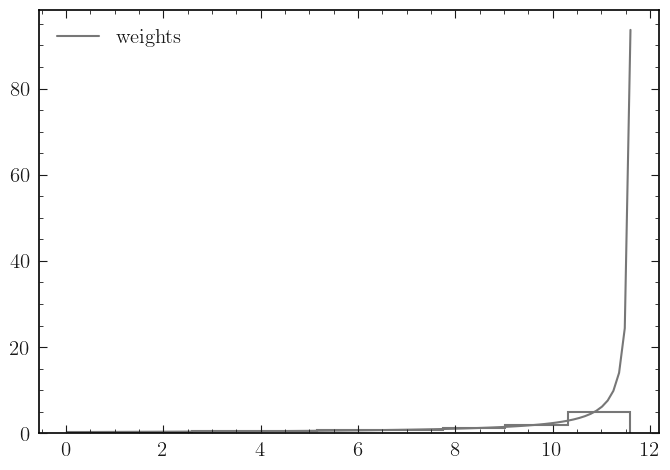

weights :  [0.28258564 0.33991724 0.41097014 0.50404404 0.63363545 0.8303997
 1.17249489 1.93303158 4.84929453]


In [52]:
cvl = 0.5
csl = 0.5

pars = (cvl, csl, fp0, fp1, fp2, f01, f02)
lims = [0.02, 11.6]
plot.dists(cmod, pars, lims)
plot.dists(cmod, pars, lims, plot_dists=False, plot_weights=True)

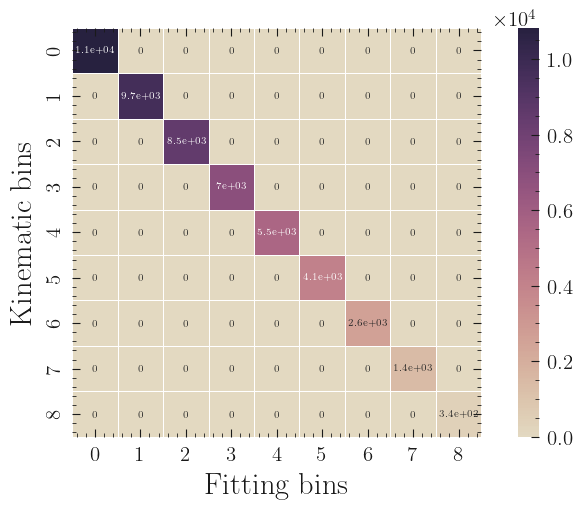

In [53]:
plot.map(cmod)

In [54]:
spec = {
  "channels": [
    {
      "name": "singlechannel",
      "samples": [
        {
          "name": "signal",
          "data": nominal,
          "modifiers": [
            {
                "name": "mu",
                "type": "normfactor",
                "data": None
            }
          ]
        },
      ]
    }
  ]
}
model = pyhf.Model(spec)

custom_mod = {
                "name": "theory",
                "type": "custom",
                "data":
                    {
                        "expr": "weight_function",
                        "ibin": [0, 1, 2, 3, 4, 5, 6, 7, 8]
                    }
              }

model = modifier.add_to_model(model, ['singlechannel'], ['signal'], cmod.expanded_pyhf, custom_mod)
data = alt_yields + model.config.auxdata
model.spec

{'channels': [{'name': 'singlechannel',
   'samples': [{'name': 'signal',
     'data': array([10829.,  9682.,  8512.,  6967.,  5510.,  4127.,  2613.,  1418.,
              342.]),
     'modifiers': [{'name': 'mu', 'type': 'normfactor', 'data': None},
      {'name': 'theory',
       'type': 'custom',
       'data': {'expr': 'weight_function',
        'ibin': [0, 1, 2, 3, 4, 5, 6, 7, 8]}}]}]}]}

In [55]:
model.config.par_map

{'cvl': {'slice': slice(0, 1, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x14fac9e498b0>},
 'csl': {'slice': slice(1, 2, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 0x14fac9e49220>},
 'FF_decorrelated[0]': {'slice': slice(2, 3, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x14fac97eb4f0>},
 'FF_decorrelated[1]': {'slice': slice(3, 4, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x14fac97eb250>},
 'FF_decorrelated[2]': {'slice': slice(4, 5, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x14fac8ebe2e0>},
 'FF_decorrelated[3]': {'slice': slice(5, 6, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x14fac8ebe640>},
 'FF_decorrelated[4]': {'slice': slice(6, 7, None),
  'paramset': <pyhf.parameters.paramsets.constrained_by_normal at 0x14fac8ebe0a0>},
 'mu': {'slice': slice(7, 8, None),
  'paramset': <pyhf.parameters.paramsets.unconstrained at 

Expected yields 
 array([3060.11993791, 3291.07870052, 3498.17781623, 3511.67481092,
       3491.33134808, 3427.05956019, 3063.72913742, 2741.03878409,
       1658.45873021])


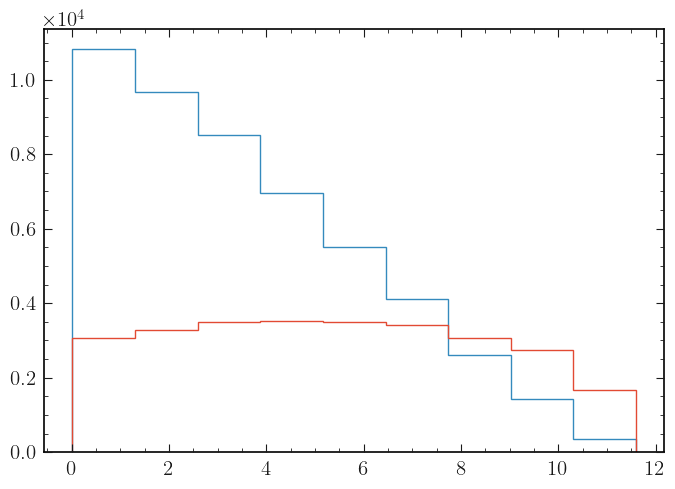

In [56]:
init = model.config.suggested_init()
init[0] = 0.5
init[1] = 0.5
expected = model.expected_actualdata(init)

print('Expected yields \n', repr(expected))

plt.stairs(nominal, binning)
plt.stairs(expected, binning)

## Perform the fit

In [57]:
fixed = model.config.suggested_fixed()
fixed[-1] = True

best_fit = pyhf.infer.mle.fit(data, model, fixed_params=fixed)

best_fit_dict = modifier.par_dict(model, best_fit)
best_fit_dict = cmod.rotate_pars(best_fit_dict)
best_fit_dict

{'cvl': 0.5000031534686942,
 'csl': 0.49999979150844587,
 'FF[0]': 0.6664405866815437,
 'FF[1]': -2.5449171886013056,
 'FF[2]': 4.7818686449657815,
 'FF[3]': 0.24893804984821466,
 'FF[4]': -0.959505696770418,
 'mu': 1.0}

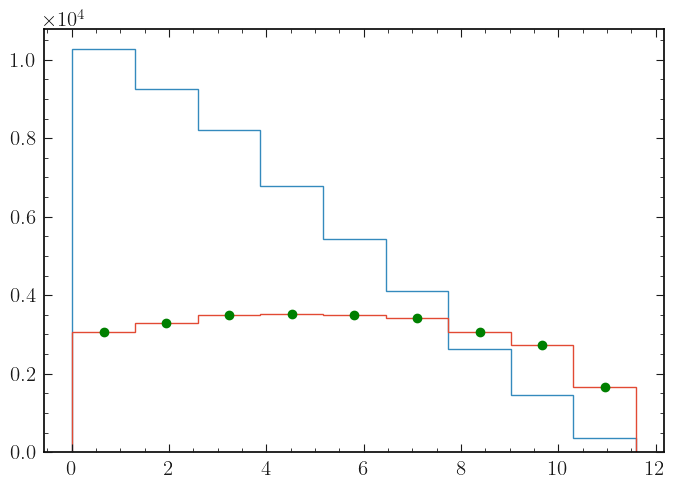

In [59]:
plt.stairs(model.expected_actualdata(model.config.suggested_init()), binning)
plt.stairs(model.expected_actualdata(best_fit), binning)
bin_cents = (binning[:-1] + binning[1:])/2
plt.plot(bin_cents, data[:9], 'og')